In [1]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import requests

from scripts.scorer import scorer
from scripts.processing import process_csv_ballots

# 1. Setup and pre-processing

In [2]:
df_projects = pd.read_csv('data/_local/rf6_projects.csv', index_col=0)
df_projects.tail(1)

,id,applicationId,projectId,name,organization,applicationCategory
87,0xfff56c5353549a3386322a5dfa17c259c3b6728d94f1...,0xfff56c5353549a3386322a5dfa17c259c3b6728d94f1...,0xd40ddc75030d57f8bad628a6563e33363f2a81ffa5fd...,Optimism Grant analytics: Grant3,OP Grants Tracker,GOVERNANCE_ANALYTICS


In [3]:
CATEGORIES = df_projects['applicationCategory'].unique()
PROJECT_CATEGORIES = df_projects.groupby('applicationCategory')['applicationId'].apply(list).to_dict()

In [4]:
raw_voting_data = process_csv_ballots('data/_local/rf6_votes.csv', project_categories=PROJECT_CATEGORIES)

NUM_VOTERS = len(raw_voting_data)
print("Ballots:", NUM_VOTERS)

Ballots: 50


In [5]:
PROJECTS = list(set([
    list(p.keys())[0] for vote in raw_voting_data
    for p in vote['project_allocations']
]))
NUM_PROJECTS = len(PROJECTS)
print("Projects:", NUM_PROJECTS)

Projects: 88


# 2. Calculate median budget totals and category allocations

In [6]:
budget_allocation = []
category_scores = defaultdict(list)
project_scores = defaultdict(lambda: defaultdict(list))
for ballot in raw_voting_data:
    
    budget_allocation.append(ballot['budget'])
    assigned_category = ballot['category_assignment']

    for category_allocations in ballot['category_allocations']:
        category = list(category_allocations.keys())[0]
        category_percentage = float(list(category_allocations.values())[0])
        category_scores[category].append(category_percentage)

    for project_allocations in ballot['project_allocations']:
        project = list(project_allocations.keys())[0]
        project_percentage = list(project_allocations.values())[0]
        if pd.isnull(project_percentage):
            continue
        project_percentage = float(project_percentage)
        project_scores[assigned_category][project].append(project_percentage)

# Step 1A. Calculate total funding for the round based on median budget vote
median_total_budget = np.median(budget_allocation)
print(f"\nMedian Budget: {median_total_budget:,.0f}")

# Step 1B. Calculate medians for categories and normalize to weights across categories
category_medians = {k: np.median(v)/100 for k, v in category_scores.items()}    
category_total = sum(category_medians.values())
category_weights = {k: v/category_total for k, v in category_medians.items()}

# Step 2. Calculate medians for projects and normalize to weights within a category
project_weights = defaultdict(lambda: defaultdict(list))
for category, project_dict in project_scores.items():
    for project, scores in project_dict.items():
        project_weights[category][project] = np.median(scores) / 100
    category_subtotal = sum(project_weights[category].values())
    for k, v in project_weights[category].items():
        project_weights[category][k] = v/category_subtotal 

# Check the results makes sense

for c in CATEGORIES:
    print("\nCategory:", c)
    print("-----------------")
    print(f"Median Allocation: {category_weights[c]*100:.3f}%")
    print("Total Projects:", len(project_weights[c]))
#     for project in project_weights[c]:
#         print(f"{project}: {project_weights[c][project]*100:,.2f}%")
    print(f"Check: Sum of Project Allocations Within Category: {sum(project_weights[c].values())*100:.1f}%\n")


Median Budget: 2,500,000

Category: GOVERNANCE_INFRA_AND_TOOLING
-----------------
Median Allocation: 39.934%
Total Projects: 46
Check: Sum of Project Allocations Within Category: 100.0%


Category: GOVERNANCE_LEADERSHIP
-----------------
Median Allocation: 29.951%
Total Projects: 20
Check: Sum of Project Allocations Within Category: 100.0%


Category: GOVERNANCE_ANALYTICS
-----------------
Median Allocation: 30.115%
Total Projects: 22
Check: Sum of Project Allocations Within Category: 100.0%



# 3. Normalize and allocate funding

In [7]:
MIN_CAP = 1_000
MAX_CAP_PCT = .125
MAX_CAP = median_total_budget * MAX_CAP_PCT

In [8]:
# Step 3. Create an initial series of project funding allocations
initial_project_allocations = pd.Series()
for category, projects in project_weights.items():
    print("\nCategory:", category, category_weights[category])
    for project, score in projects.items():
        normalized_score = score * category_weights[category]
        #print(f"{project}: {normalized_score*100:.2f}%")
        initial_project_allocations.loc[project] = normalized_score * median_total_budget


Category: GOVERNANCE_ANALYTICS 0.30115309738930757

Category: GOVERNANCE_INFRA_AND_TOOLING 0.3993410872061099

Category: GOVERNANCE_LEADERSHIP 0.2995058154045824


Final Results:
 - Projects: 88
 - Voters: 50
 - Funding Available: 2500000.0
 - Funding Awarded: 2500000


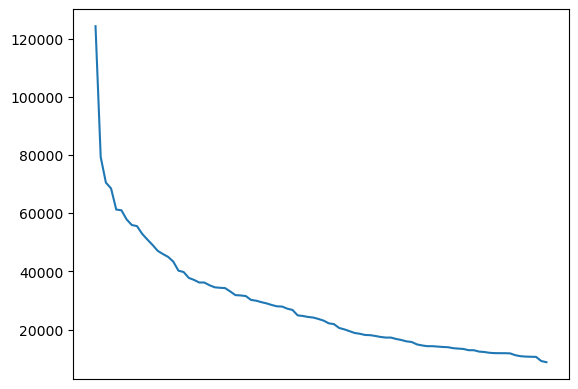

In [9]:
def allocate_funding(project_scores, funding_balance):
    """
    Helper for allocating and redistributing funding balances
    """
    score_balance = project_scores.sum()
    allocations = pd.Series()
    
    for project, score in project_scores.sort_values(ascending=False).items():
        uncapped_funding_alloc = score / score_balance * funding_balance
        capped_funding_alloc = min(uncapped_funding_alloc, MAX_CAP)
        allocations.loc[project] = capped_funding_alloc
        funding_balance -= capped_funding_alloc
        score_balance -= score

    return allocations

# Step 4. Implement max cap and redistribute excess
capped_allocations = allocate_funding(initial_project_allocations, median_total_budget)

# Step 5. Set the funding for projects below the minimum cap to 0
capped_allocations.loc[capped_allocations < MIN_CAP] = 0

# Step 6. Allocate the remaining funding to projects below the maximum cap
max_cap_funding = capped_allocations[capped_allocations == MAX_CAP].sum()
remaining_funding = median_total_budget - max_cap_funding
remaining_projects = capped_allocations[capped_allocations < MAX_CAP]
capped_allocations.update(allocate_funding(remaining_projects, funding_balance=remaining_funding))

# Check the results
capped_allocations.plot(xticks=[])
print("Final Results:")
print(" - Projects:", NUM_PROJECTS)
print(" - Voters:", NUM_VOTERS)
print(" - Funding Available:", median_total_budget)
print(" - Funding Awarded:", round(capped_allocations.sum()))

In [10]:
export_data = capped_allocations.copy().rename('rf6Reward').reset_index()
export_data.rename(columns={'index': 'projectId'}, inplace=True)
pc = {}
for c, plist in PROJECT_CATEGORIES.items():
    for p in plist:
        pc.update({p:c})
export_data['category'] = export_data['projectId'].map(pc)

(
    export_data.set_index('projectId')
    .join(df_projects.set_index('applicationId')['name'])
    .to_csv('data/_local/rf6_results.csv')
)